In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
from time import time

import numpy as np
import pandas as pd
import xarray as xr
from sklearn.linear_model import LinearRegression
from scipy import signal
import xrscipy.signal as dsp

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cmocean import cm
import hvplot.xarray

import gsw

from niwtools.tools import *
from niwtools.qc import *
from epsilon_tools import *

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

purp = pd.read_pickle('../data/purp_colormap.pkl')
# set up figure params
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1.3)
mpl.rc('figure', dpi=100, figsize=[12, 6])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

xr.set_options(display_style="text", display_width=100,warn_for_unclosed_files=True);

In [33]:
floatid = '7781a'
test = xr.open_dataset(f'../data/xarray/xr_{floatid}.nc')

In [34]:
floatid = '7781a'
raw = xr.open_dataset(f'../data/xarray/xr_{floatid}.nc')
cfs = xr.open_dataset('../data/metdata/float_cfs_hourly.nc')
cfs = cfs.sel(floatid=f'{floatid}')

In [35]:
# need to relax the qc criteria a bit because of heaving due to larger surface gravity waves
raw = qc_velocity(raw, RotPmax = 20, verrmax = 0.1)
raw['mld'] = ('time', raw.z.where(raw.S2 == raw.S2.max(dim='z')).mean(dim='z'))

In [63]:
raw = raw.sel(time=slice('2016-10-04','2016-10-19'))

In [64]:
# bandpass between low*f and high*f
f = gsw.f(40.7)/(2*np.pi)
raw = bandpass_velocity(raw, 0.75*f, 1.25*f)

/Users/sebastianessink/Dropbox (MIT)/niw/src/niwtools/niwtools/tools.py:114: UnevenSamplingWarning: Average sampling 6.43e+03 != first sampling step 9.73e+03
  T = ( dsp.get_sampling_step(raw, dim='dtime') )


In [396]:
2*np.pi/(0.75*gsw.f(40.7))/86400

1.0195492760426883

In [65]:
raw = add_cfs_data(raw, floatid)

0.14592178099778075
0.24320296832963462
0.14592178099778075
0.24320296832963462


/Users/sebastianessink/Dropbox (MIT)/niw/src/niwtools/niwtools/tools.py:160: UnevenSamplingWarning: Average sampling 6.43e+03 != first sampling step 9.73e+03
  T = ( dsp.get_sampling_step(raw, dim='dtime') )
/Users/sebastianessink/Dropbox (MIT)/niw/src/niwtools/niwtools/tools.py:160: UnevenSamplingWarning: Average sampling 6.43e+03 != first sampling step 9.73e+03
  T = ( dsp.get_sampling_step(raw, dim='dtime') )


## Horizontal kinetic energy (HKE)

In [66]:
mask = ~np.isnan(raw.u) & ~np.isnan(raw.v)

In [67]:
rho0=raw.rho0.mean()
raw['hkeNI'] = 0.5*rho0*( raw.uNI**2 + raw.vNI**2) # that gonna be in [J m^{-3}]
raw['hkeTOT'] = 0.5*rho0*( raw.u**2 + raw.v**2)

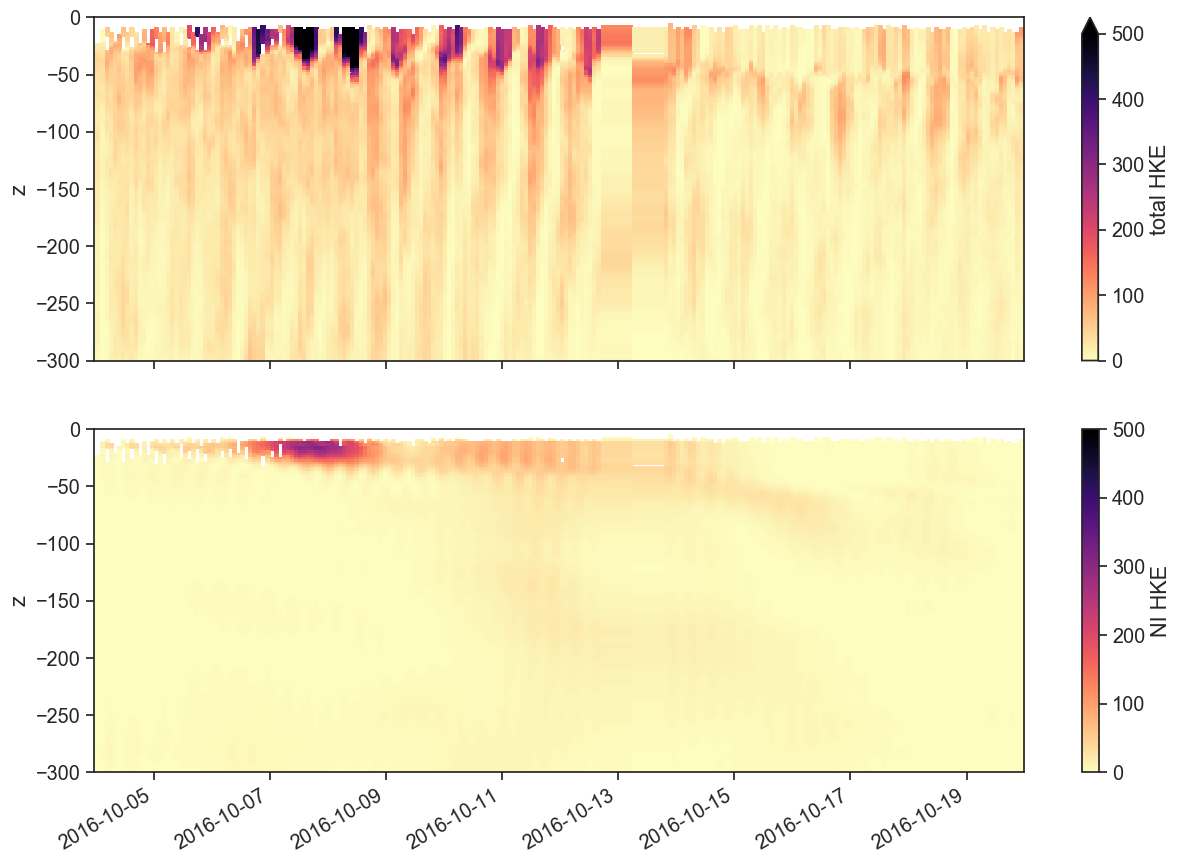

In [68]:
zmin = -300
f, (ax0, ax1) = plt.subplots(2,1,figsize=(15,10), sharex=True) 
raw.hkeTOT.where(mask).plot(cmap='magma_r',vmin=0, vmax=500, ax=ax0, cbar_kwargs={'label': 'total HKE'})
ax0.set_ylim(zmin,0)
ax0.set_xlabel(None)

raw.hkeNI.where(mask).plot(cmap='magma_r',vmin=0, vmax=500, ax=ax1, cbar_kwargs={'label': 'NI HKE'})
ax1.set_ylim(zmin,0)
ax1.set_xlabel(None);

In [69]:
raw['dudz'] = raw.u.differentiate('z',)
raw['dvdz'] = raw.v.differentiate('z')
raw['S'] = 0.5*(raw.dudz**2 + raw.dvdz**2)

raw['dudzNI'] = raw.uNI.differentiate('z')
raw['dvdzNI'] = raw.vNI.differentiate('z')
raw['SNI'] = 0.5*(raw.dudzNI**2 + raw.dvdzNI**2)

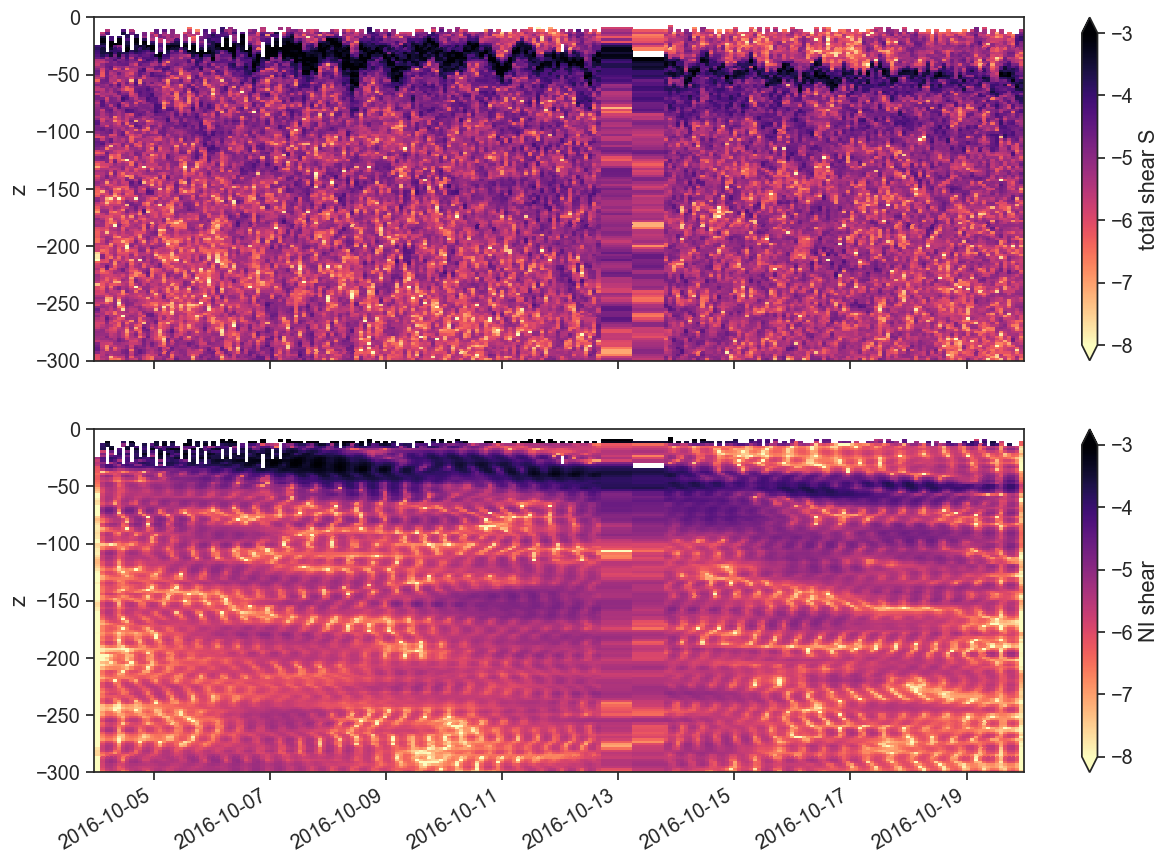

In [70]:
zmin = -300
f, (ax0, ax1) = plt.subplots(2,1,figsize=(15,10), sharex=True) 
raw.S.pipe(np.log10).plot(cmap='magma_r',vmin=-8, vmax=-3, ax=ax0, cbar_kwargs={'label': 'total shear S'})
ax0.set_ylim(zmin,0)
ax0.set_xlabel(None)

raw.SNI.pipe(np.log10).plot(cmap='magma_r',vmin=-8, vmax=-3, ax=ax1, cbar_kwargs={'label': 'NI shear'})
ax1.set_ylim(zmin,0)
ax1.set_xlabel(None);

In [71]:
dfdu = 0.5*( compute_spectra(raw,'dudz').mean('dtime')**2 + compute_spectra(raw,'dvdz').mean('dtime')**2)
dfduNI =  0.5*( compute_spectra(raw,'dudzNI').mean('dtime')**2 + compute_spectra(raw,'dvdzNI').mean('dtime')**2)

/Users/sebastianessink/Dropbox (MIT)/niw/src/niwtools/niwtools/tools.py:296: UnevenSamplingWarning: Average sampling 6.43e+03 != first sampling step 9.73e+03
  fs=86400/dsp.get_sampling_step(raw, dim='dtime'), nperseg=128 )
/Users/sebastianessink/Dropbox (MIT)/niw/src/niwtools/niwtools/tools.py:296: UnevenSamplingWarning: Average sampling 6.43e+03 != first sampling step 9.73e+03
  fs=86400/dsp.get_sampling_step(raw, dim='dtime'), nperseg=128 )
/Users/sebastianessink/Dropbox (MIT)/niw/src/niwtools/niwtools/tools.py:296: UnevenSamplingWarning: Average sampling 6.43e+03 != first sampling step 9.73e+03
  fs=86400/dsp.get_sampling_step(raw, dim='dtime'), nperseg=128 )
/Users/sebastianessink/Dropbox (MIT)/niw/src/niwtools/niwtools/tools.py:296: UnevenSamplingWarning: Average sampling 6.43e+03 != first sampling step 9.73e+03
  fs=86400/dsp.get_sampling_step(raw, dim='dtime'), nperseg=128 )


/usr/local/anaconda3/lib/python3.7/site-packages/xarray/plot/plot.py:965: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(x[0], x[-1])


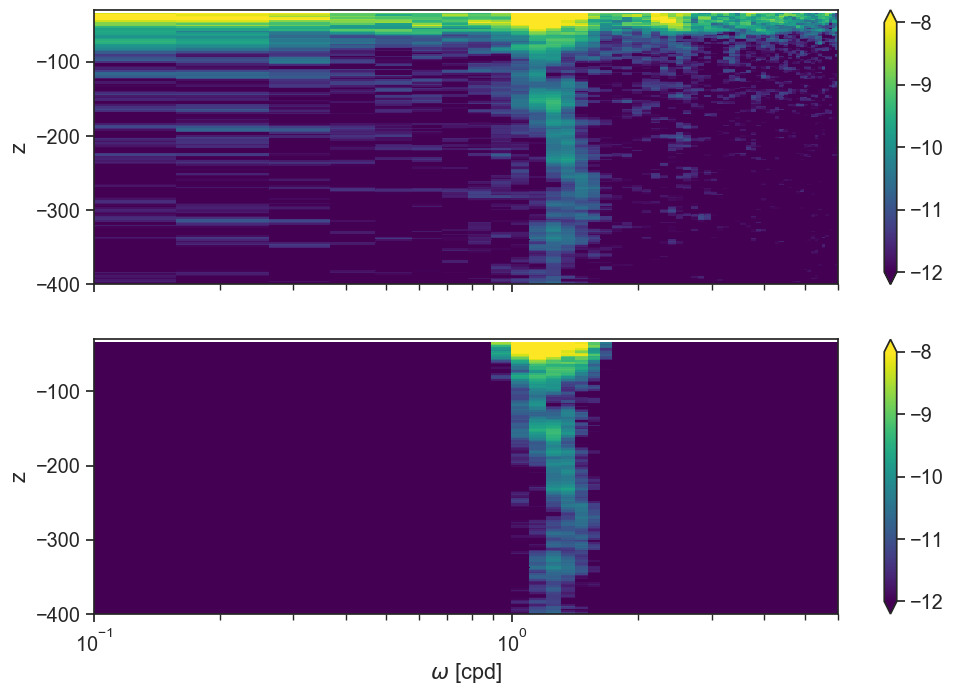

In [72]:
fig,ax = plt.subplots(2,1, figsize=(12,8), sharex=True) 

dfdu.pipe(np.log10).plot(cmap='viridis',vmin=-12, vmax=-8, ax=ax[0])
ax[0].set_ylim(-400,-30)
ax[0].set_xlim(1e-1,6e0)
ax[0].set_title(None);
ax[0].set_xlabel(None)
ax[0].set_xscale('log')

dfduNI.pipe(np.log10).plot(cmap='viridis',vmin=-12, vmax=-8, ax=ax[1])
ax[1].set_ylim(-400,-30)
ax[1].set_xlim(1e-1,6e0)
ax[1].set_title(None);
ax[1].set_xlabel('$\omega$ [cpd]')
ax[1].set_xscale('log')

In [73]:
dfu = compute_spectra(raw,'u').mean('dtime')
dfv = compute_spectra(raw,'v').mean('dtime')
dft = 0.5*(dfu+dfv)

dfniu = compute_spectra(raw,'uNI').mean('dtime')
dfniv = compute_spectra(raw,'vNI').mean('dtime')
dfnit = 0.5* (dfniu+dfniv)

/Users/sebastianessink/Dropbox (MIT)/niw/src/niwtools/niwtools/tools.py:296: UnevenSamplingWarning: Average sampling 6.43e+03 != first sampling step 9.73e+03
  fs=86400/dsp.get_sampling_step(raw, dim='dtime'), nperseg=128 )
/Users/sebastianessink/Dropbox (MIT)/niw/src/niwtools/niwtools/tools.py:296: UnevenSamplingWarning: Average sampling 6.43e+03 != first sampling step 9.73e+03
  fs=86400/dsp.get_sampling_step(raw, dim='dtime'), nperseg=128 )
/Users/sebastianessink/Dropbox (MIT)/niw/src/niwtools/niwtools/tools.py:296: UnevenSamplingWarning: Average sampling 6.43e+03 != first sampling step 9.73e+03
  fs=86400/dsp.get_sampling_step(raw, dim='dtime'), nperseg=128 )
/Users/sebastianessink/Dropbox (MIT)/niw/src/niwtools/niwtools/tools.py:296: UnevenSamplingWarning: Average sampling 6.43e+03 != first sampling step 9.73e+03
  fs=86400/dsp.get_sampling_step(raw, dim='dtime'), nperseg=128 )


/usr/local/anaconda3/lib/python3.7/site-packages/xarray/plot/plot.py:965: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(x[0], x[-1])


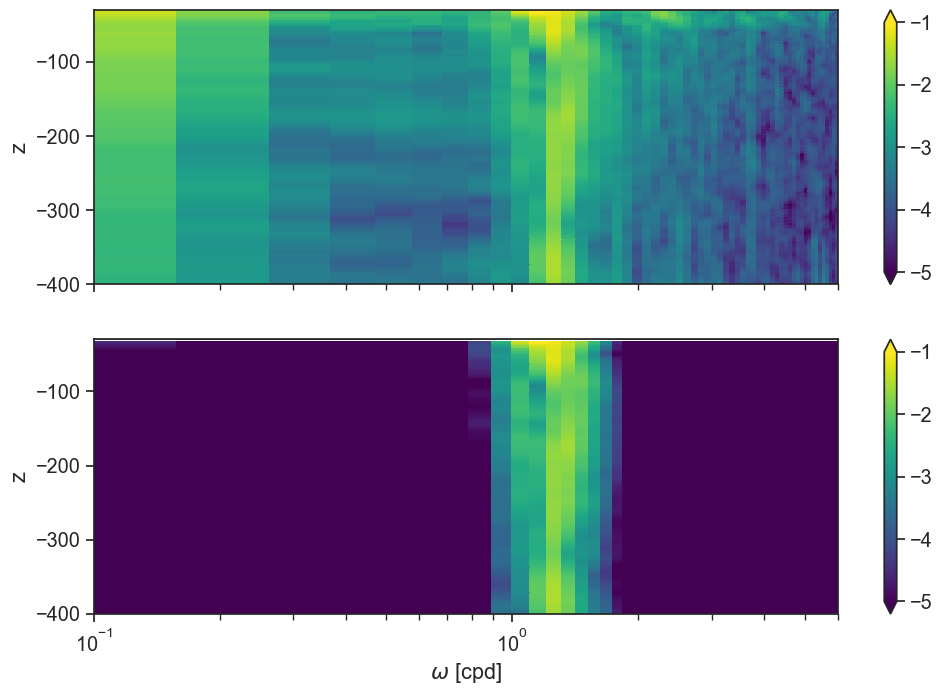

In [74]:
fig,ax = plt.subplots(2,1, figsize=(12,8), sharex=True) 

dft.pipe(np.log10).plot(cmap='viridis', vmin=-5, vmax=-1, ax=ax[0])
ax[0].set_ylim(-400,-30)
ax[0].set_xlim(1e-1,6e0)
ax[0].set_title(None);
ax[0].set_xlabel(None)
ax[0].set_xscale('log')

dfnit.pipe(np.log10).plot(cmap='viridis', vmin=-5, vmax=-1, ax=ax[1])
ax[1].set_ylim(-400,-30)
ax[1].set_xlim(1e-1,6e0)
ax[1].set_title(None);
ax[1].set_xlabel('$\omega$ [cpd]')
ax[1].set_xscale('log')

In [75]:
gsw.f(40)*86400/(2*np.pi)

1.2890948565868658

In [76]:
dft.pipe(np.log10).squeeze().hvplot(x='frequency', groupby='z')*dfnit.pipe(np.log10).squeeze().hvplot(x='frequency', groupby='z',)

:DynamicMap   [z]
   :Overlay
      .NdOverlay.I  :NdOverlay   [pressure]
         :Curve   [frequency]   (value)
      .NdOverlay.II :NdOverlay   [pressure]
         :Curve   [frequency]   (value)

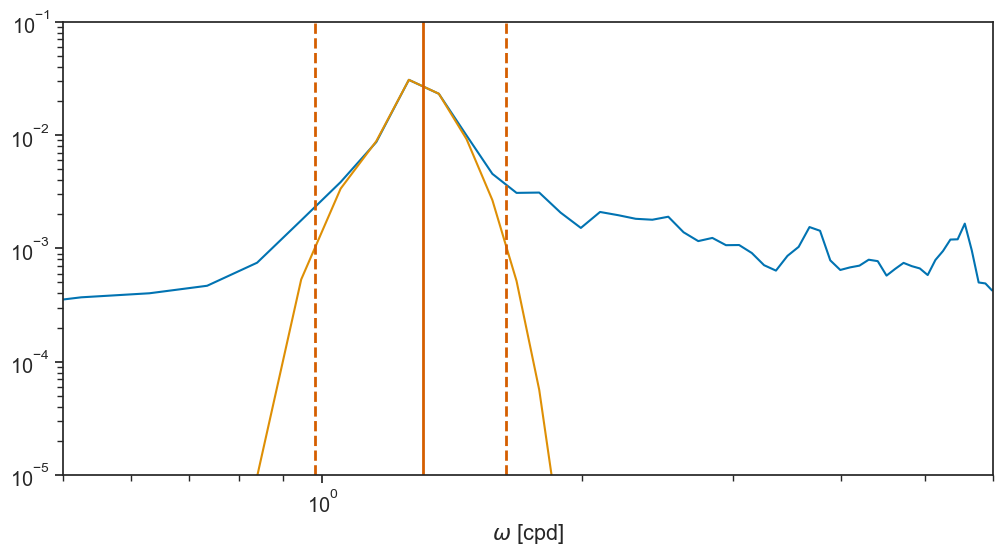

In [77]:
(dft*dft.frequency).mean('z').plot(label='total')
(dfnit*dfnit.frequency).mean('z').plot(label='bandpass')

latmean = 40.7
plt.axvline(gsw.f(latmean)*86400/(2*np.pi), lw=2, color='r')
plt.axvline(0.75*gsw.f(latmean)*86400/(2*np.pi), ls='dashed', lw=2, color='r')
plt.axvline(1.25*gsw.f(latmean)*86400/(2*np.pi), ls='dashed', lw=2, color='r')


plt.xlim(5e-1,6e0)
plt.ylim(1e-5,1e-1)
plt.title(None);
plt.xlabel('$\omega$ [cpd]')
plt.xscale('log')
plt.yscale('log')

In [78]:
# integrate energy vertically
# raw = raw.swap_dims({'dtime':'time'})
zmin = -300
raw['mld'] = ('time', raw.z.where(raw.S2 == raw.S2.max(dim='z')).mean(dim='z'))
raw['hke_ml_ni'] = ('time', integrate_columns(raw.hkeNI, raw.mld,0))
raw['hke_py_ni'] = ('time', integrate_columns(raw.hkeNI, zmin, raw.mld))
raw['hke_ml'] = ('time', integrate_columns(raw.hkeTOT, raw.mld,0))
raw['hke_py'] = ('time', integrate_columns(raw.hkeTOT, zmin, raw.mld))

In [79]:
# just to check takes simple averages
ml_mask = (raw.z>raw.mld) & (raw.z<0)
py_mask = (raw.z>zmin) & (raw.z<raw.mld)
raw['hke_ml_ni'] = raw.hkeNI.where(ml_mask).mean(dim='z')
raw['hke_py_ni'] = raw.hkeNI.where(py_mask).mean(dim='z')
raw['hke_ml'] = raw.hkeTOT.where(ml_mask).mean(dim='z')
raw['hke_py'] = raw.hkeTOT.where(py_mask).mean(dim='z')

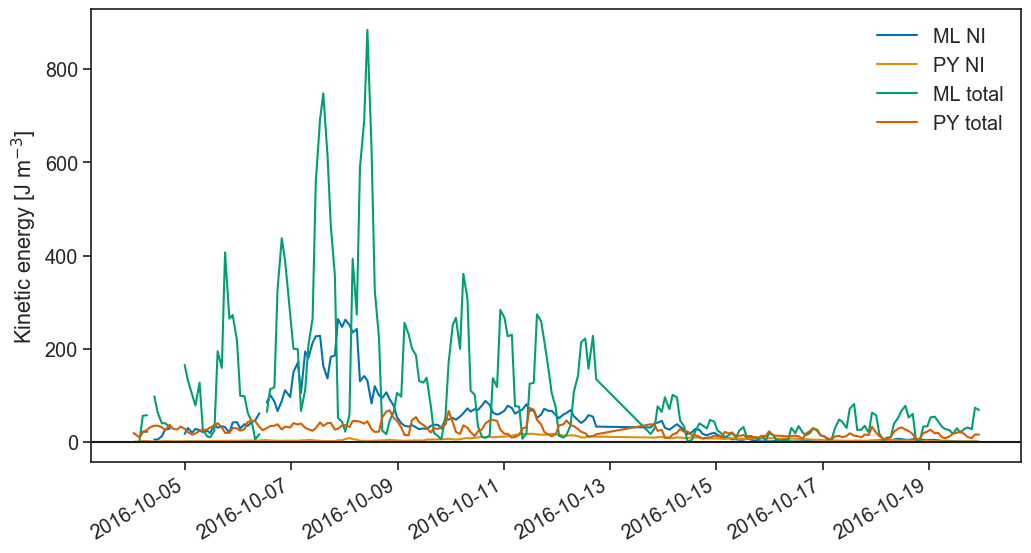

In [81]:
raw['hke_ml_ni'].plot(label='ML NI')
raw['hke_py_ni'].plot(label='PY NI')
raw['hke_ml'].plot(label='ML total')
raw['hke_py'].plot(label='PY total')
plt.ylabel('Kinetic energy [J m$^{-3}$]')
plt.xlabel(None)
plt.axhline(0, color='k')
plt.legend();

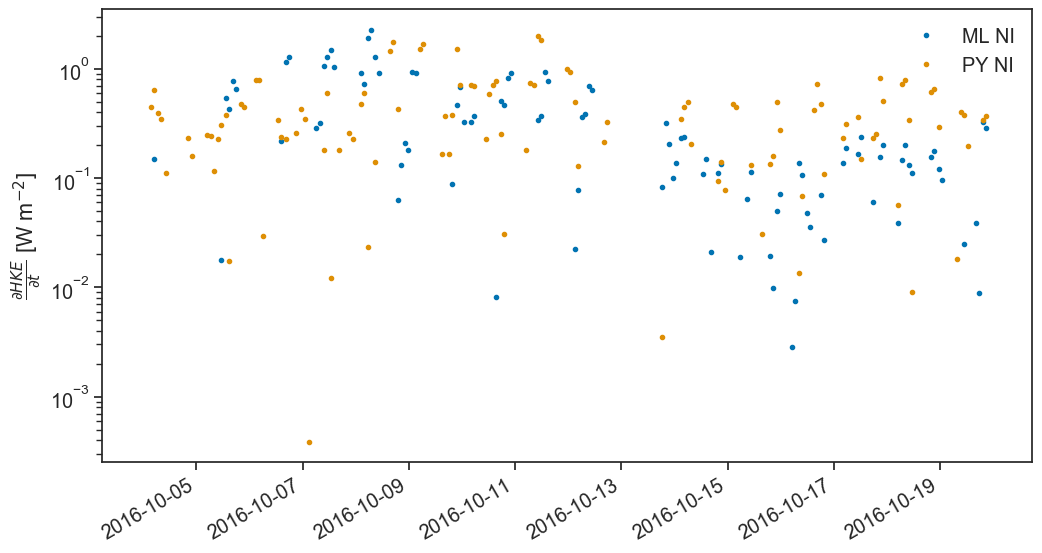

In [82]:
# take time derivatvies
raw['dhke_ml'] = (-raw['hke_ml']*raw.mld).differentiate('time',datetime_unit='s')
raw['dhke_ml_ni'] = (-raw['hke_ml_ni']*raw.mld).differentiate('time',datetime_unit='s')
raw['dhke_py'] = (raw['hke_py']*(400-raw.mld)).differentiate('time',datetime_unit='s')
raw['dhke_py_ni'] = (raw['hke_py_ni']*(400-raw.mld)).differentiate('time',datetime_unit='s')

raw.dhke_ml.plot(label='ML NI', marker='.', lw=0)
raw.dhke_py.plot(label='PY NI', marker='.', lw=0)

# (raw['hke_ml_ni'].differentiate('time',datetime_unit='s')*raw.mld).plot(label='ML NI')
# (raw['hke_py_ni'].differentiate('time',datetime_unit='s')*raw.mld).plot(label='PY NI')
# raw['hke_ml'].differentiate('time',datetime_unit='s').plot(label='ML total')
# raw['hke_py'].differentiate('time',datetime_unit='s').plot(label='PY total')

plt.ylabel(r'$\frac{\partial HKE}{\partial t}$ [W m$^{-2}$]')
plt.xlabel(None)
plt.legend();
plt.yscale('log')

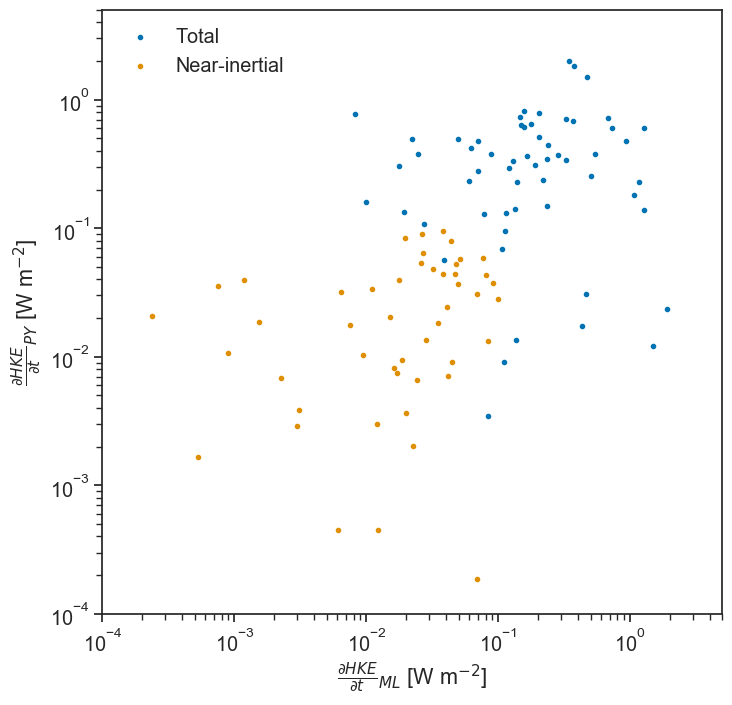

In [83]:
plt.figure(figsize=(8,8))
plt.scatter(raw.dhke_ml,raw.dhke_py, marker='.', label='Total')
plt.scatter(raw.dhke_ml_ni,raw.dhke_py_ni, marker='.', label='Near-inertial')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-4,5e0)
plt.ylim(1e-4,5e0)
# plt.axis('equal')
plt.xlabel(r'$\frac{\partial HKE}{\partial t}_{ML}$ [W m$^{-2}$]')
plt.ylabel(r'$\frac{\partial HKE}{\partial t}_{PY}$ [W m$^{-2}$]')
plt.legend(loc=2)

## Wind work $\mathbf{\tau} \cdot \mathbf{u}$

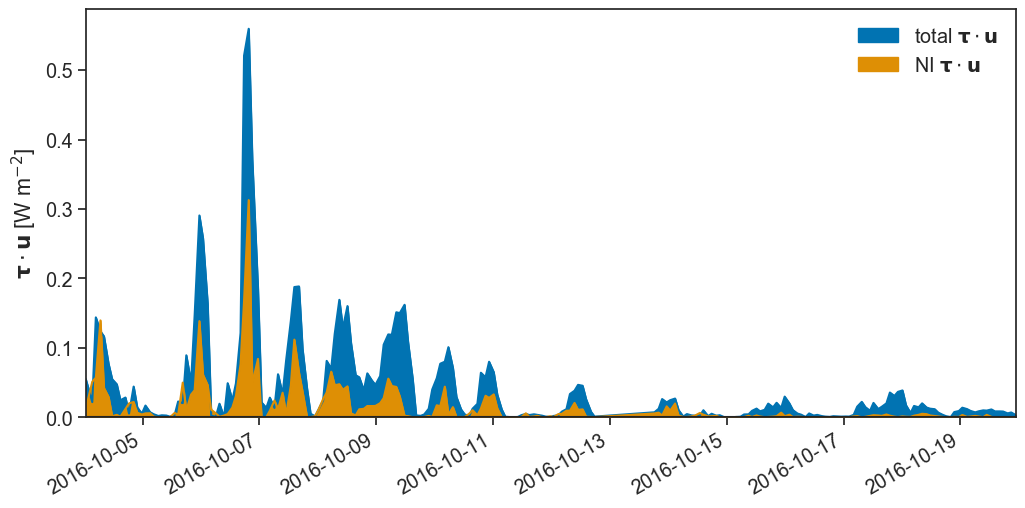

In [84]:
# raw.tau.sel(time=slice('2016-10-01','2016-10-21')).plot(label='tau')
raw.taudotu.to_series().abs().plot.area(label=r'total $\mathbf{\tau} \cdot \mathbf{u}$')
raw.taudotu_ni.to_series().abs().plot.area(label=r'NI $\mathbf{\tau} \cdot \mathbf{u}$')
# raw.taudotu_ni_ni.plot(label='both NI')
plt.ylabel(r'$\mathbf{\tau} \cdot \mathbf{u}$ [W m$^{-2}$]')
plt.xlabel(None)
plt.axhline(0, color='k')
plt.legend()
# plt.yscale('log')

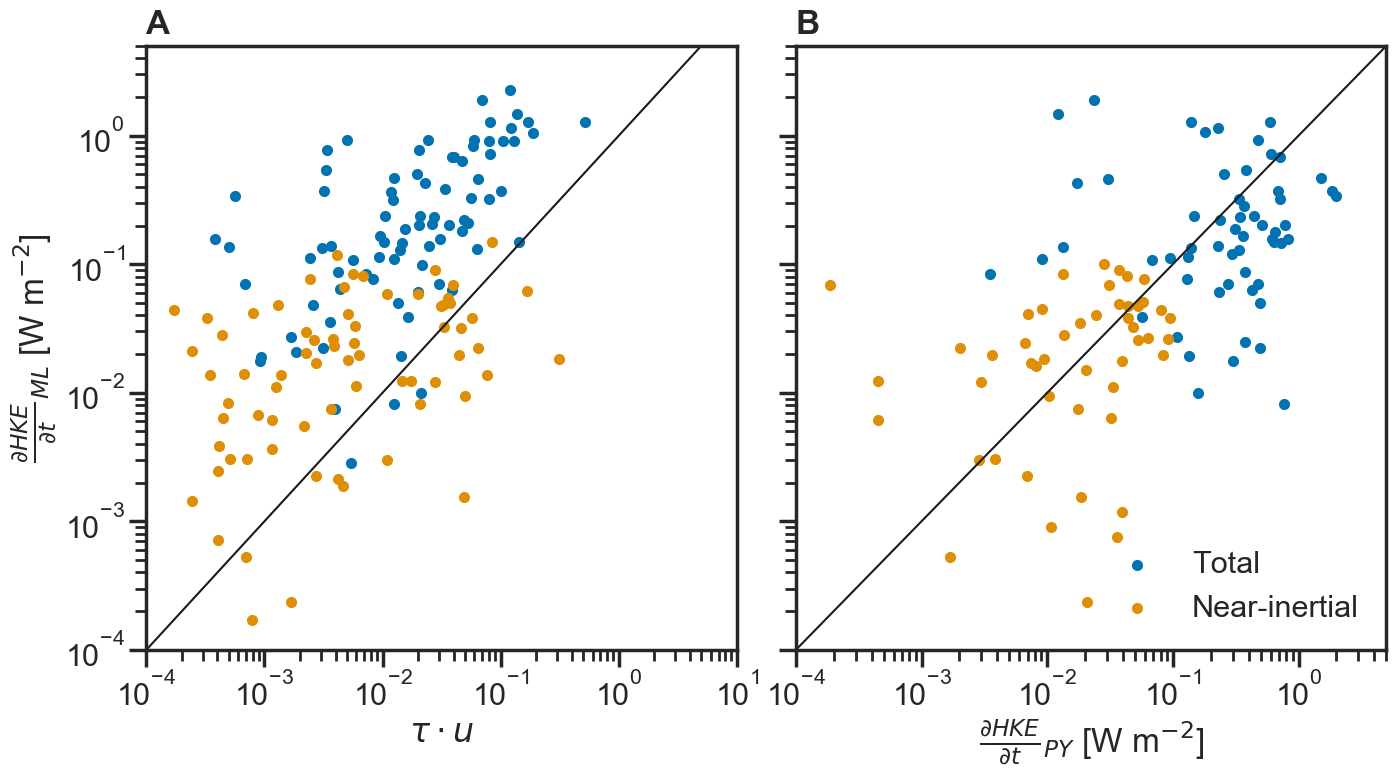

In [85]:
# set up figure params
sns.set(style='ticks', context='poster', palette='colorblind')
f, ax = plt.subplots(1,2, figsize=(16,8), sharey=True)

ax[0].scatter(raw.taudotu,raw.dhke_ml, marker='.', label='Total')
ax[0].scatter(raw.taudotu_ni,raw.dhke_ml_ni, marker='.', label='Near-inertial')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlim(1e-4,1e1)
ax[0].set_ylim(1e-4,1e1)
ax[0].set_xlabel(r'$\tau \cdot u$')
ax[0].set_ylabel(r'$\frac{\partial HKE}{\partial t}_{ML}$ [W m$^{-2}$]')
ax[0].plot([1e-4, 1e1],[1e-4,1e1], label='_Near-inertial', color='k', lw=1.5)

ax[1].scatter(raw.dhke_py,raw.dhke_ml, marker='.', label='Total')
ax[1].scatter(raw.dhke_py_ni,raw.dhke_ml_ni, marker='.', label='Near-inertial')
ax[1].plot([1e-4, 1e1],[1e-4,1e1], label='_Near-inertial', color='k', lw=1.5)
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlim(1e-4,5e0)
ax[1].set_ylim(1e-4,5e0)
# ax[1].set_ylabel(r'$\frac{\partial HKE}{\partial t}_{ML}$ [W m$^{-2}$]')
ax[1].set_xlabel(r'$\frac{\partial HKE}{\partial t}_{PY}$ [W m$^{-2}$]')
ax[1].legend()
plt.subplots_adjust(wspace=0.1)

alphabet(ax)
plt.savefig('../figures/transfers_ryu.pdf')

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UnevenSamplingWarning: Average sampling 6.43e+03 != first sampling step 9.73e+03
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UnevenSamplingWarning: Average sampling 6.43e+03 != first sampling step 9.73e+03
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UnevenSamplingWarning: Average sampling 6.43e+03 != first sampling step 9.73e+03
  after removing the cwd from sys.path.


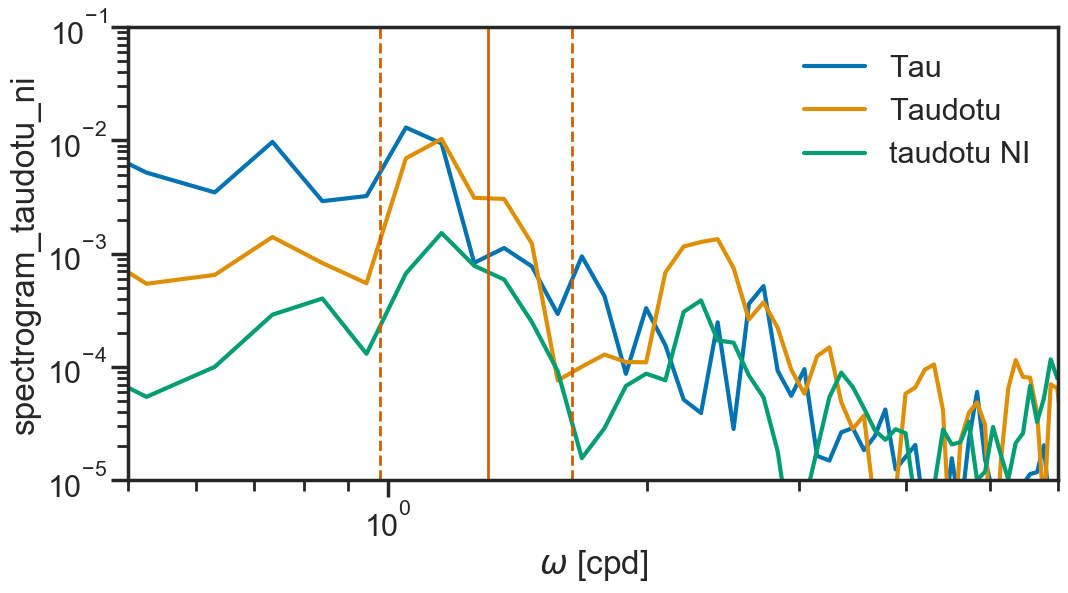

In [90]:
compute_spectra_cfs(raw,'tau').mean('dtime').plot(label='Tau')
compute_spectra_cfs(raw,'taudotu').mean('dtime').plot(label='Taudotu')
compute_spectra_cfs(raw,'taudotu_ni').mean('dtime').plot(label='taudotu NI')

latmean = 40.7
plt.axvline(gsw.f(latmean)*86400/(2*np.pi), lw=2, color='r')
plt.axvline(0.75*gsw.f(latmean)*86400/(2*np.pi), ls='dashed', lw=2, color='r')
plt.axvline(1.25*gsw.f(latmean)*86400/(2*np.pi), ls='dashed', lw=2, color='r')


plt.xlim(5e-1,6e0)
plt.ylim(1e-5,1e-1)
plt.title(None);
plt.xlabel('$\omega$ [cpd]')
plt.xscale('log')
plt.yscale('log')
plt.legend();

## Availabel potential energy (APE)

(-100, 0)

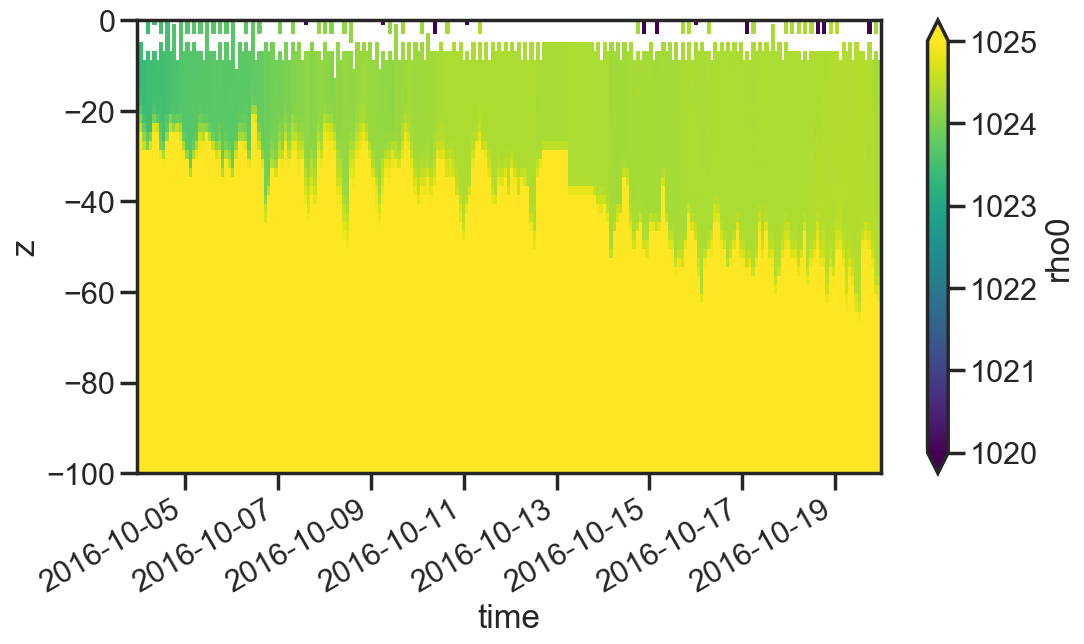

In [92]:
raw.rho0.plot(vmin=1020, vmax=1025)
plt.ylim(-100,0)

In [93]:
f = gsw.f(40.7)/(2*np.pi)
raw = lowpass_variable(raw,'rho0', 0.6*f, 1.25*f)

0.1167374247982246
0.24320296832963462


/Users/sebastianessink/Dropbox (MIT)/niw/src/niwtools/niwtools/tools.py:236: UnevenSamplingWarning: Average sampling 6.43e+03 != first sampling step 9.73e+03
  T = ( dsp.get_sampling_step(raw, dim='dtime') )


In [94]:
dfr_low = compute_spectra(raw,'rho0LOW').mean('dtime')
dfr = compute_spectra(raw,'rho0').mean('dtime')

/Users/sebastianessink/Dropbox (MIT)/niw/src/niwtools/niwtools/tools.py:296: UnevenSamplingWarning: Average sampling 6.43e+03 != first sampling step 9.73e+03
  fs=86400/dsp.get_sampling_step(raw, dim='dtime'), nperseg=128 )
/Users/sebastianessink/Dropbox (MIT)/niw/src/niwtools/niwtools/tools.py:296: UnevenSamplingWarning: Average sampling 6.43e+03 != first sampling step 9.73e+03
  fs=86400/dsp.get_sampling_step(raw, dim='dtime'), nperseg=128 )


(-9, -2)

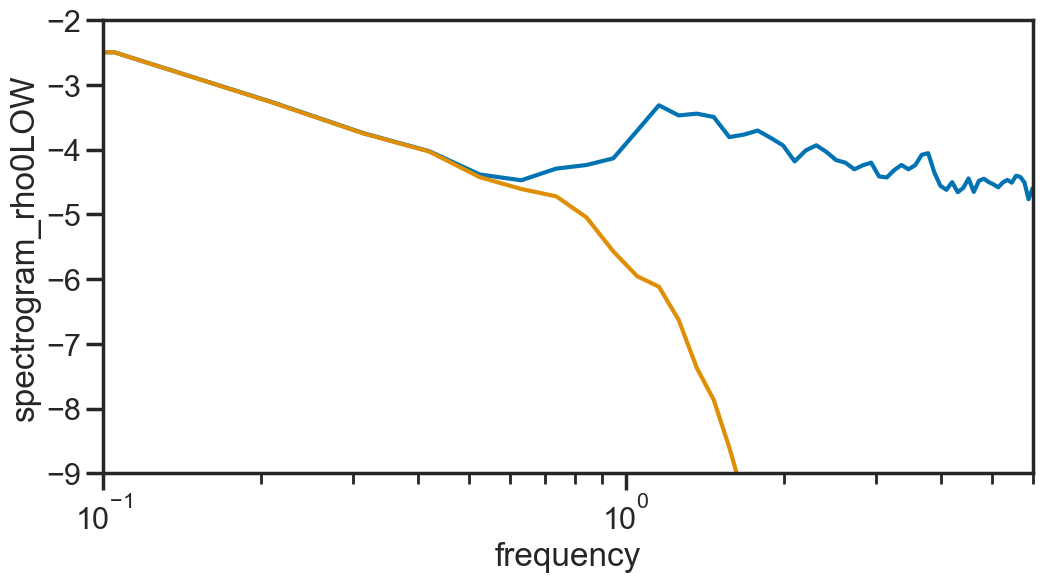

In [95]:
dfr.pipe(np.log10).mean('z').plot(xscale='log')
dfr_low.pipe(np.log10).mean('z').plot(xscale='log')
plt.xlim(1e-1,6e0)
plt.ylim(-9,-2)

In [174]:
# raw['rho_ref'] = raw.rho0.rolling(time=5, center=True).mean()
# raw['rho_ref'] = background_raw.rho0.mean('time')
raw['rho_ref'] = raw.rho0LOW
raw['rho_prime'] = raw.rho0 - raw.rho_ref
raw['rho_prime'] = raw.rho_prime.where(raw.z<-10,0).where(raw.z>-400,0)

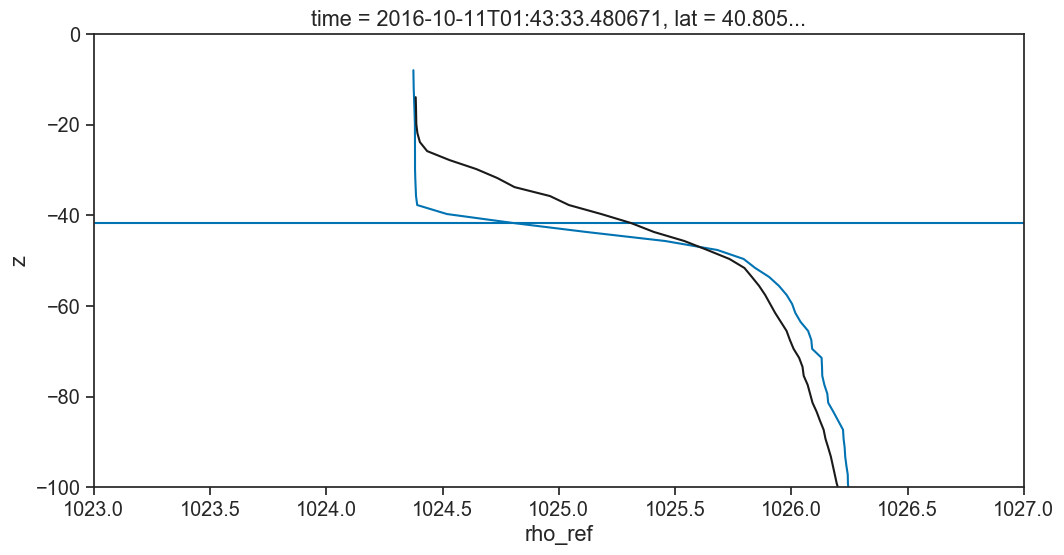

In [175]:
# for i in range(200,210):
#     (raw.rho0.isel(time=i)).plot(y='z')
i=100
(raw.rho0.isel(time=i)).plot(y='z')
plt.axhline(raw.mld.isel(time=i))
plt.ylim(-100,0)
plt.xlim(1023,1027)
raw.rho_ref.isel(time=i).plot(y='z',color='k')

Text(0.5, 1.0, 'rho prime')

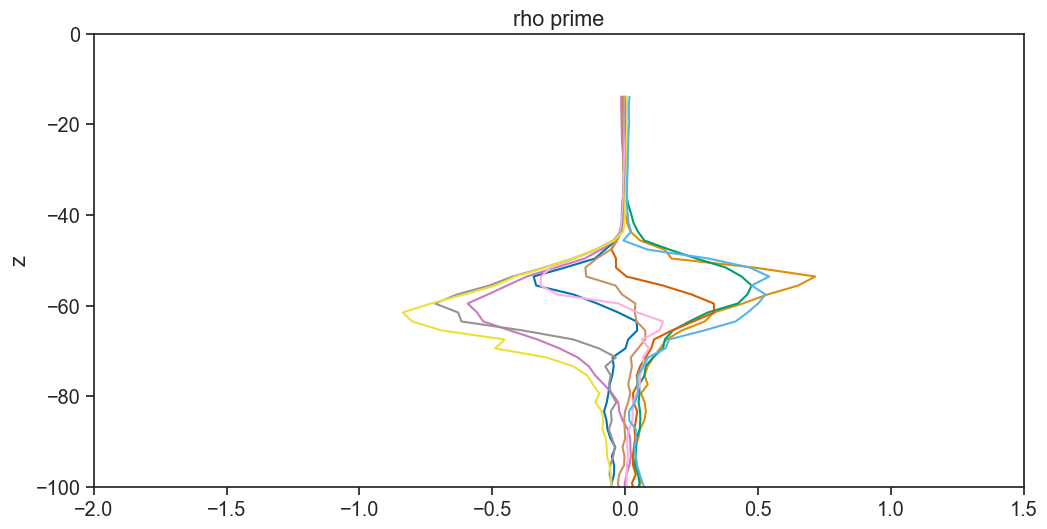

In [176]:
for i in range(200,210):
    (raw.rho0.isel(time=i)- raw.rho_ref.isel(time=i)).plot(y='z')
plt.xlim(-2,1.5)
plt.ylim(-100,0)
plt.title('rho prime')

(-100, 0)

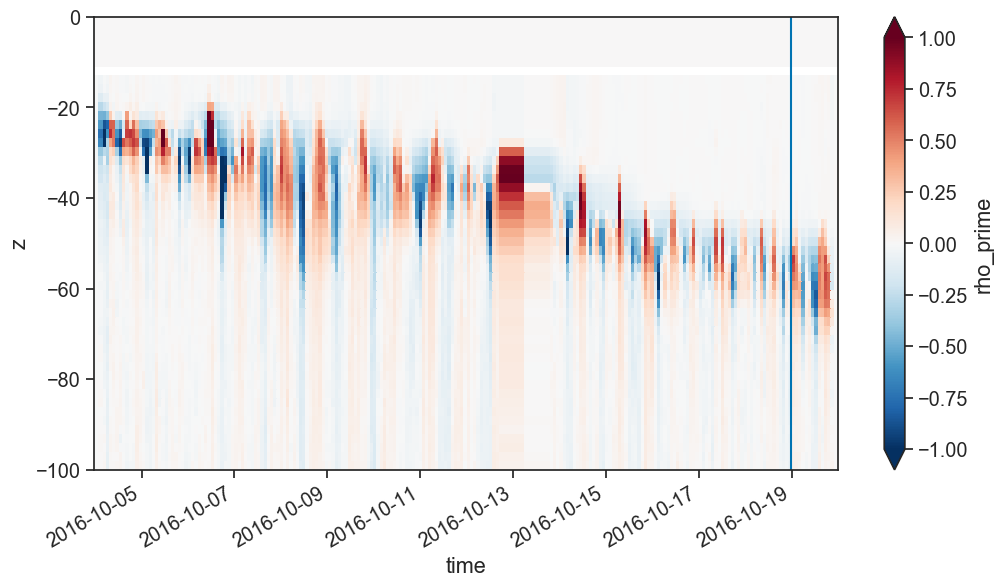

In [177]:
raw.rho_prime.plot(vmin=-1,vmax=1, cmap='RdBu_r')
plt.axvline(raw.time.isel(time=200).values)
plt.ylim(-100,0)

In [145]:
array = []
# TODO: could do better here with simpson's rule
prof = raw.isel(time=t)
prof = prof.dropna(dim='z', how='any', subset=['rho_prime','rho0','rho_ref'])
prof = prof[['rho_ref','rho0','rho_prime']]

proff = prof.swap_dims({'z':'rho_ref'}).sortby('rho_ref')
if prof.rho_ref.size>0:
    prof['zref'] = ('z', proff.interp(rho_ref=prof.rho0.values).z)
    prof['ape'] = ('z', compute_ape(prof) )
    array.append(prof)
else:
    array.append(np.nan)

8.8 s ± 272 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [302]:
%%timeit
(data.z >= z1) & (data.z <= z2)

30.6 ms ± 1.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [303]:
mask = (data.z >= z1) & (data.z <= z2)

In [314]:
data.where( (data.z >= -120) & (data.z <= -80) ).dropna('z').integrate('z')

<xarray.DataArray 'rho_prime' ()>
array(-0.00118323)
Coordinates:
    dtime    float64 1.375e+06
    time     datetime64[ns] 2016-10-19T22:42:41.728779
    lon      float64 150.7
    lat      float64 40.76

In [291]:
def integral(data,z1,z2):
    if z2>z1:
        data = data.where( (data.z >= z1) & (data.z <= z2) )
        sign= 1
    else:
        data = data.where( (data.z >= z2) & (data.z <= z1) )
        sign= -1
    data['z'] = data.z*sign
    array = []
    return data.dropna('z').integrate('z')

In [297]:
np.max( [z1,z2] )

-33.73579741940266

In [285]:
%%timeit
data.where( (data.z >= z1) & (data.z <= z2) ) # this is a problem because sometimes it will be the opposite order

30.8 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [294]:
raw.time.max()

<xarray.DataArray 'time' ()>
array('2016-10-19T22:42:41.728779000', dtype='datetime64[ns]')

In [114]:
start = time()

array = []
for t in range(raw.time.size):
    # TODO: could do better here with simpson's rule
    prof = raw.isel(time=t)
    prof = prof.dropna(dim='z', how='any', subset=['rho_prime','rho0','rho_ref'])
    prof = prof[['rho_ref','rho0','rho_prime']]
    
    proff = prof.swap_dims({'z':'rho_ref'}).sortby('rho_ref')
    if prof.rho_ref.size>0:
        prof['zref'] = ('z', proff.interp(rho_ref=prof.rho0.values).z)
        prof['ape'] = ('z', compute_ape(prof) )
        array.append(prof)
    else:
        array.append(np.nan)
        
cleanedList = [x for x in array if type(x)!=float]
new = xr.concat(cleanedList, dim='time')

print( (time()-start)/60 )

63.369827401638034


In [115]:
raw['ape'] = new.ape.transpose()
raw['hke_ape'] = raw.hkeNI/raw.ape

In [116]:
raw = raw.sel(time=slice('2016-10-04','2016-10-19'))

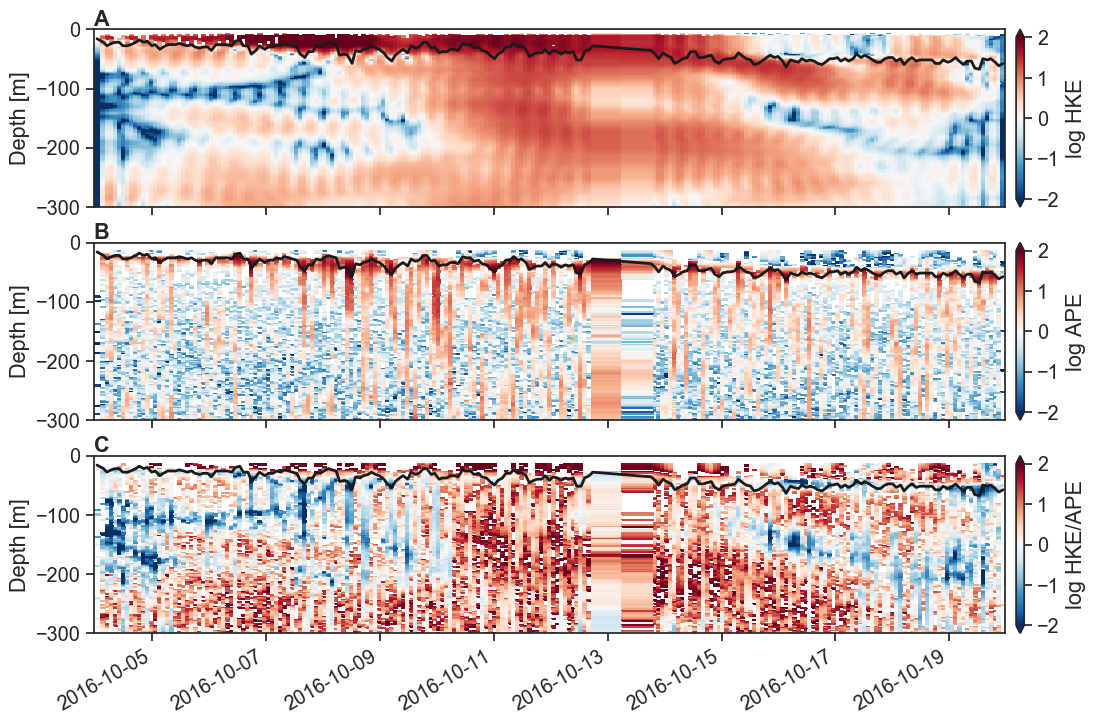

In [117]:
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1.3)
f, ax = plt.subplots(3,1, sharex=True, figsize=(14,8))

raw.hkeNI.pipe(np.log10).plot(vmin=-2, vmax=2, cmap='RdBu_r', ax=ax[0], rasterized=True,
                             cbar_kwargs={'pad':0.01,'label':'log HKE'})
raw.mld.plot(color='k', lw=2, ax=ax[0])
ax[0].set_ylim(-300,0)
ax[0].set_xlabel(None)
ax[0].set_ylabel('Depth [m]')


raw.ape.pipe(np.log10).plot(vmin=-2, vmax=2, cmap='RdBu_r', ax=ax[1], rasterized=True,
                           cbar_kwargs={'pad':0.01,'label':'log APE'})
raw.mld.plot(color='k', lw=2,ax=ax[1])
ax[1].set_ylim(-300,0)
ax[1].set_xlabel(None)
ax[1].set_ylabel('Depth [m]')

raw.hke_ape.pipe(np.log10).plot(vmin=-2, vmax=2, cmap='RdBu_r', ax=ax[2], rasterized=True,
                               cbar_kwargs={'pad':0.01,'label':'log HKE/APE'})
raw.mld.plot(color='k', lw=2, ax=ax[2])
ax[2].set_ylim(-300,0)
ax[2].set_xlabel(None)
ax[2].set_ylabel('Depth [m]')

alphabet(ax)

plt.savefig('../figures/hke_ape.pdf')

In [118]:
2*np.pi/gsw.f(40.7)/3600

18.351886968768387

(-400, 0)

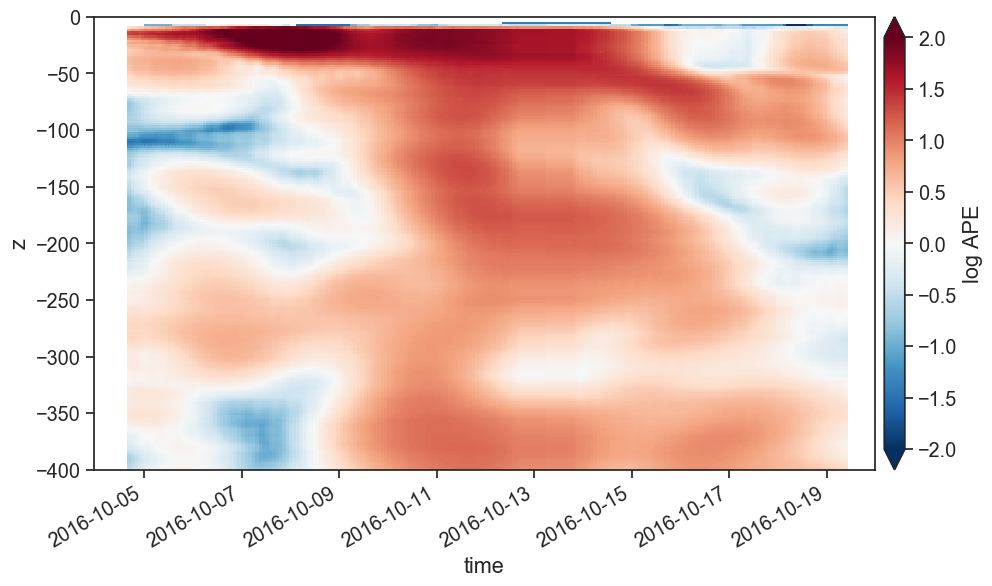

In [119]:
raw.hkeNI.fillna(0).rolling(time=18, center=True).mean().pipe(np.log10).plot(vmin=-2, vmax=2, cmap='RdBu_r', rasterized=True,
                           cbar_kwargs={'pad':0.01,'label':'log APE'})
plt.ylim(-400,0)

(-400, 0)

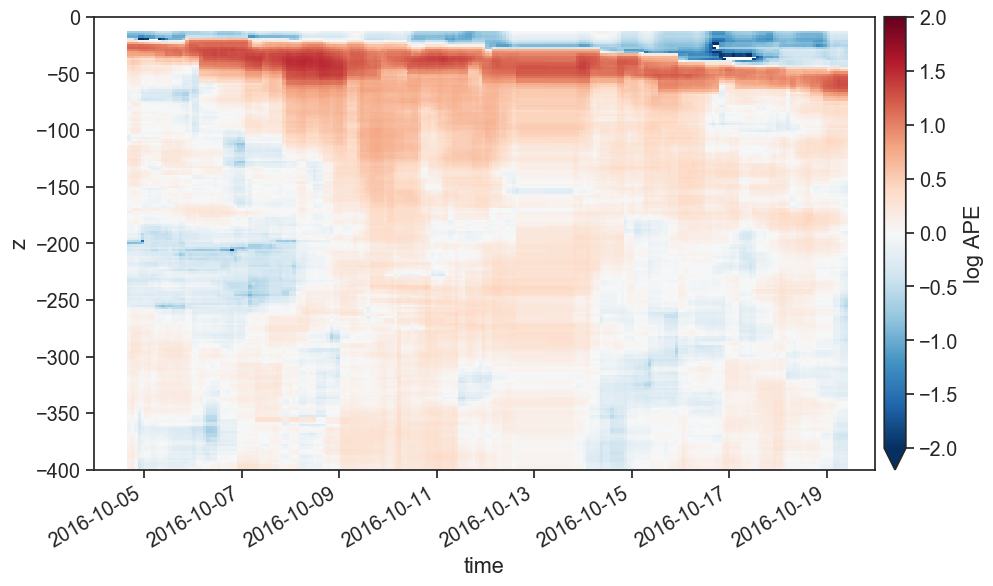

In [120]:
raw.ape.rolling(time=18, center=True).mean().pipe(np.log10).plot(vmin=-2, vmax=2, cmap='RdBu_r', rasterized=True,
                           cbar_kwargs={'pad':0.01,'label':'log APE'})
plt.ylim(-400,0)

In [121]:
a = raw.ape.rolling(time=18, center=True).mean()
b = raw.hkeNI.fillna(0).rolling(time=18, center=True).mean()

(-200, 0)

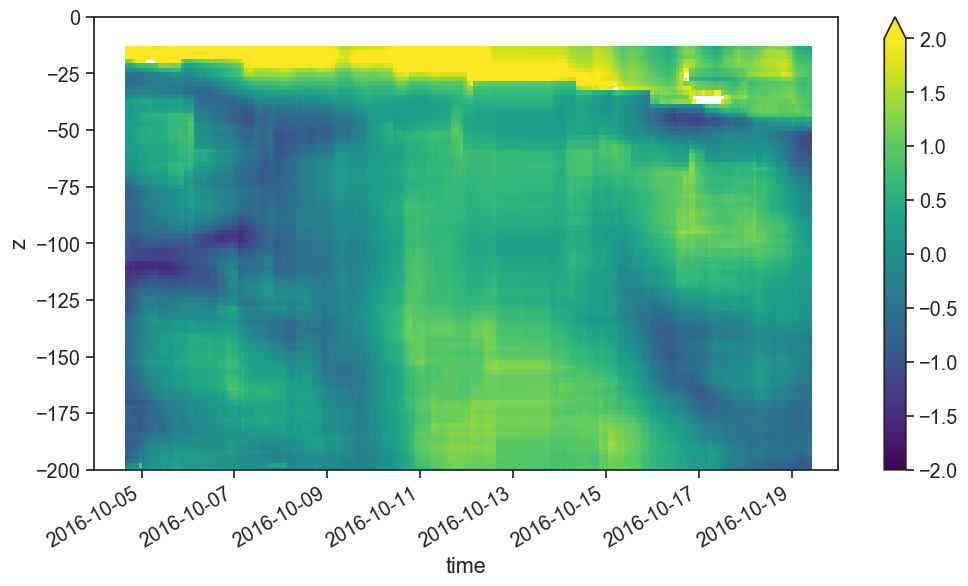

In [122]:
(b/a).pipe(np.log10).plot(vmin=-2,vmax=2)
plt.ylim(-200,0)

In [123]:
# just to check takes simple averages
ml_mask = (raw.z>raw.mld) & (raw.z<0)
py_mask = (raw.z>zmin) & (raw.z<raw.mld)
raw['ape_ml'] = raw.ape.where(ml_mask).mean(dim='z')
raw['ape_py'] = raw.ape.where(py_mask).mean(dim='z')

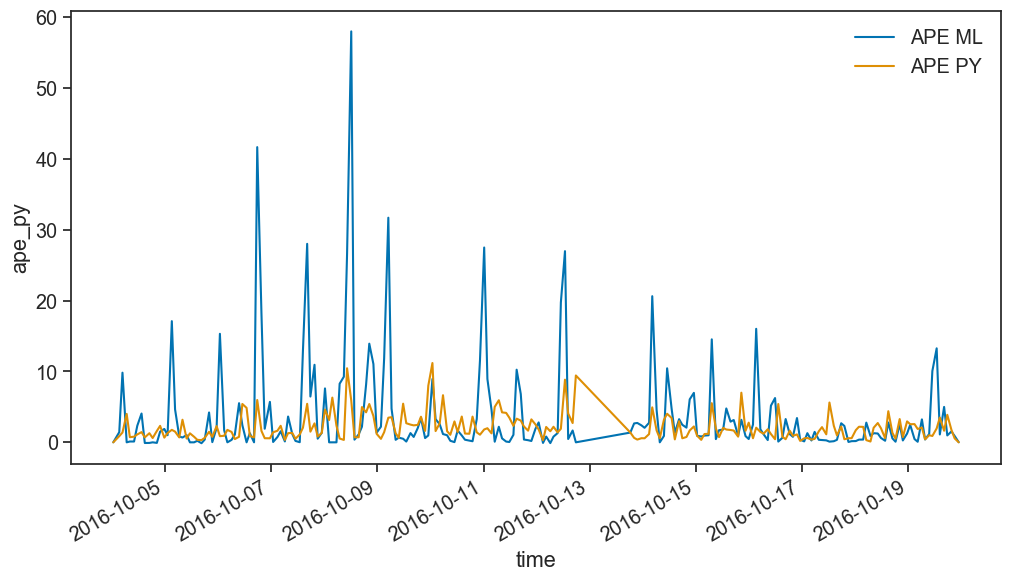

In [124]:
(raw.ape_ml).plot(label='APE ML')
(raw.ape_py).plot(label='APE PY')
plt.legend()

In [125]:
raw['dape_ml'] = (-raw['ape_ml']*raw.mld).differentiate('time',datetime_unit='s')
raw['dape_py'] =(raw['ape_py']*(400+raw.mld)).differentiate('time',datetime_unit='s')

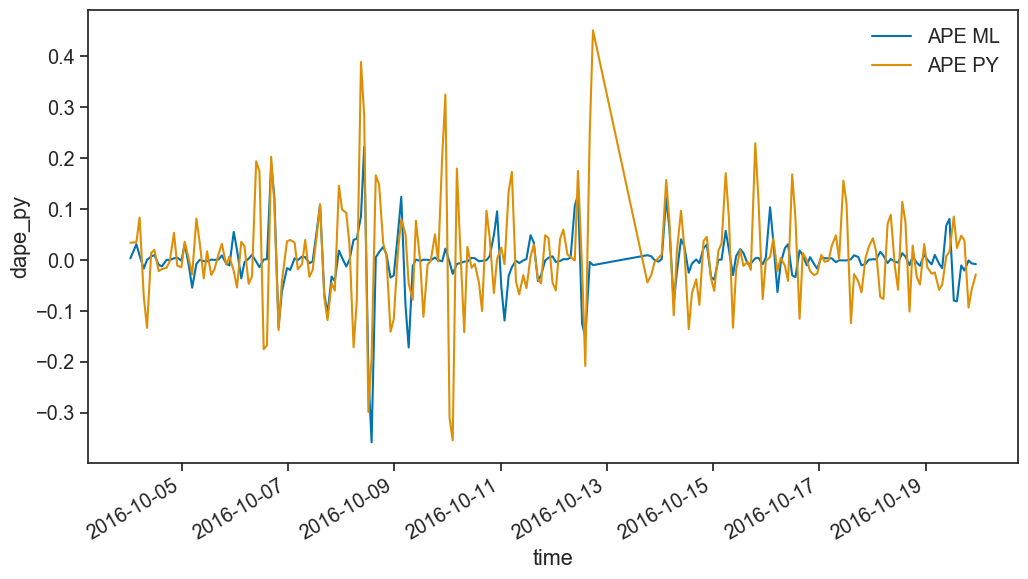

In [126]:
raw.dape_ml.plot(label='APE ML')
raw.dape_py.plot(label='APE PY')
plt.legend()

Text(0, 0.5, '$\\frac{\\partial APE}{\\partial t}_{PY}$ [W m$^{-2}$]')

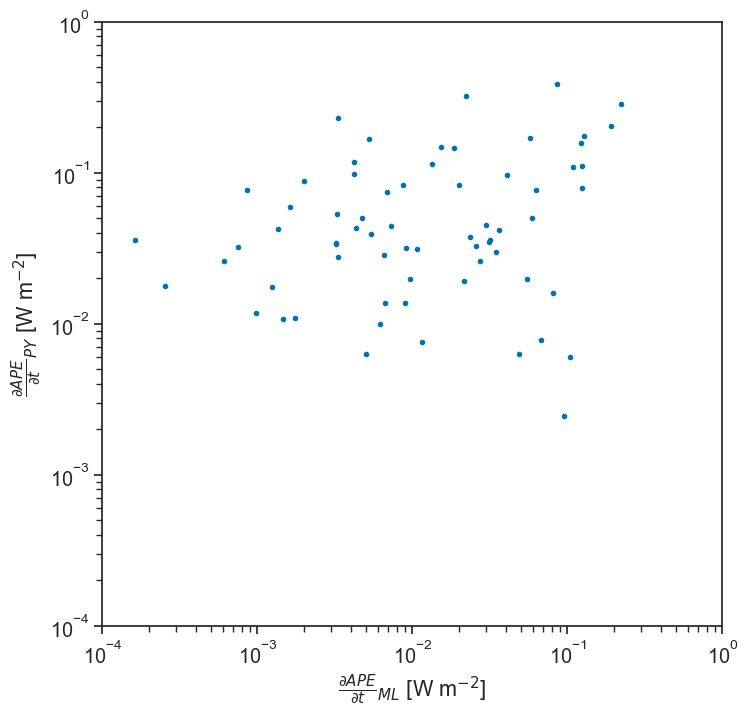

In [127]:
plt.figure(figsize=(8,8))
plt.scatter(raw.dape_ml,raw.dape_py, marker='.')
# plt.scatter(raw.taudotu,raw.dhke_ml, marker='.')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-4,1e0)
plt.ylim(1e-4,1e0)
# plt.axis('equal')
plt.xlabel(r'$\frac{\partial APE}{\partial t}_{ML}$ [W m$^{-2}$]')
plt.ylabel(r'$\frac{\partial APE}{\partial t}_{PY}$ [W m$^{-2}$]')

Text(0, 0.5, '$\\frac{\\partial APE}{\\partial t}$ [W m$^{-2}$]')

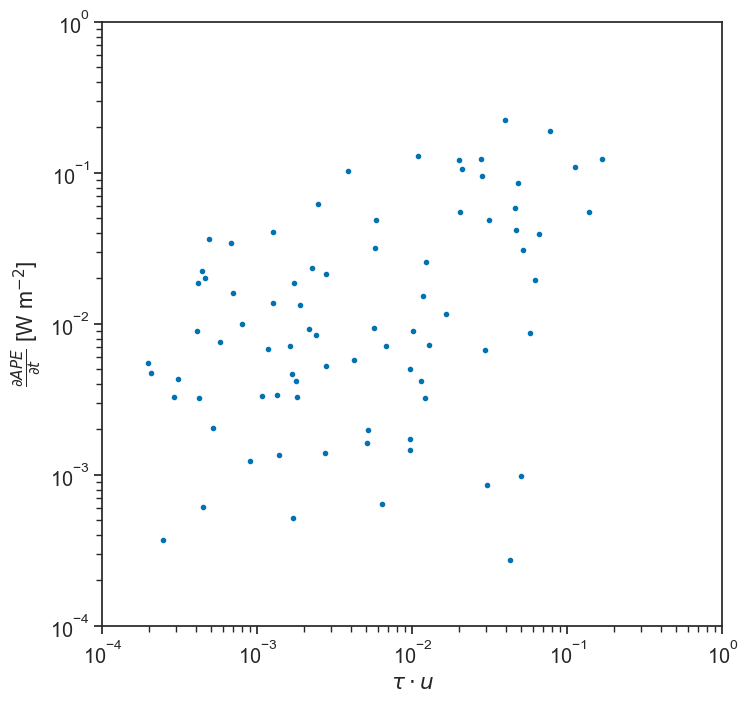

In [128]:
plt.figure(figsize=(8,8))
plt.scatter(raw.taudotu_ni,raw.dape_ml, marker='.')
# plt.scatter(raw.taudotu,raw.dhke_ml, marker='.')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-4,1e0)
plt.ylim(1e-4,1e0)
# plt.axis('equal')
plt.xlabel(r'$\tau \cdot u$')
plt.ylabel(r'$\frac{\partial APE}{\partial t}$ [W m$^{-2}$]')

## Epsilon $\epsilon$

In [129]:
raw = qc_turbulence(raw)

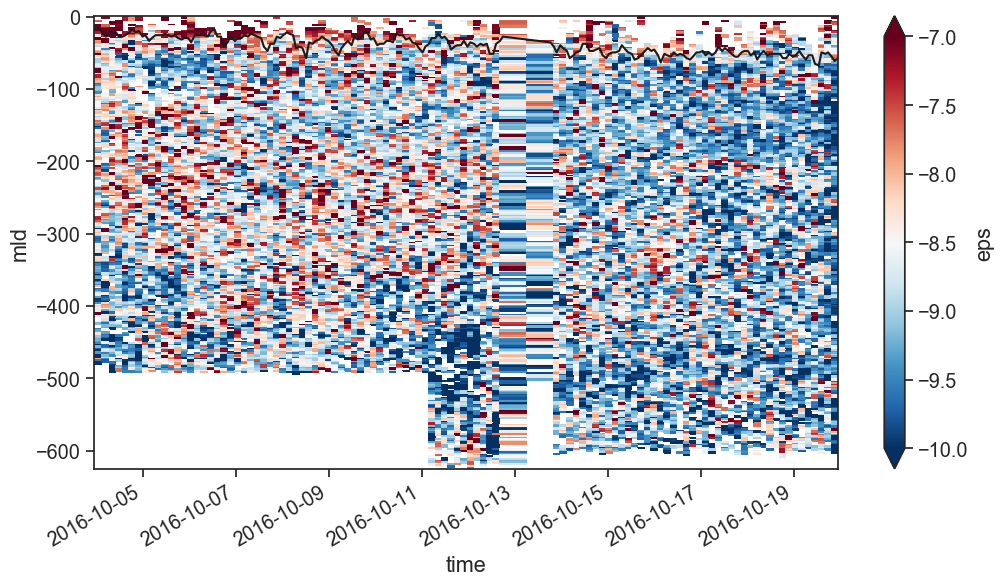

In [393]:
raw.eps.dropna('time', how='all').dropna('z', how='all').pipe(np.log10).plot(vmin=-10, vmax=-7, cmap='RdBu_r')
raw.mld.plot(color='k')

In [192]:
# just to check takes simple averages
ml_mask = (raw.z>raw.mld) & (raw.z<0)
py_mask = (raw.z>zmin) & (raw.z<raw.mld)
raw['eps_ml'] = -raw.mld*raw.eps.where(ml_mask).fillna(0).mean(dim='z')*rho0
raw['eps_py'] = (400-raw.mld)*raw.eps.where(py_mask).fillna(0).mean(dim='z')*rho0

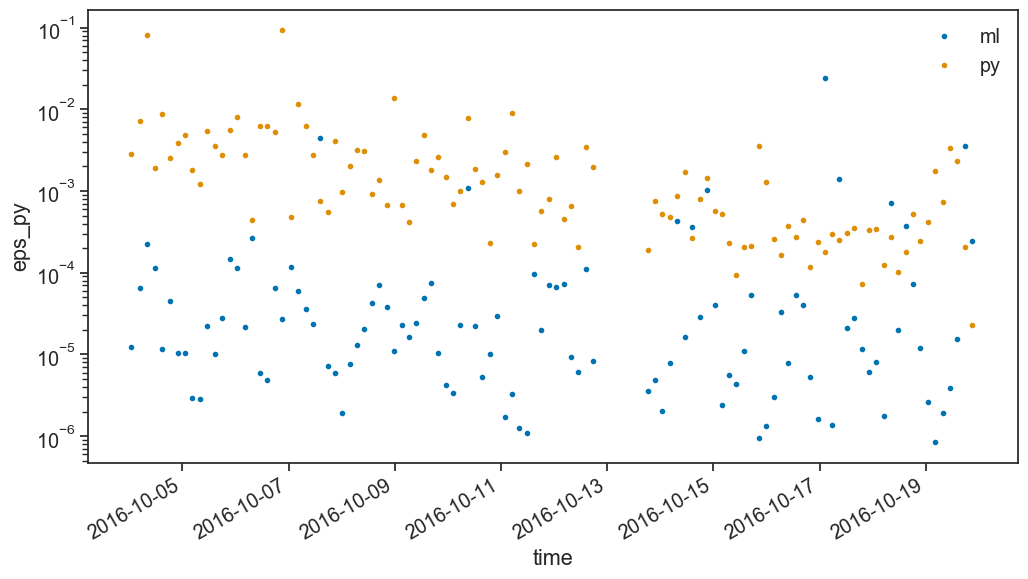

In [196]:
raw['eps_ml'].plot(label='ml',marker='.', lw=0)
raw['eps_py'].plot(label='py',marker='.', lw=0)
plt.yscale('log')
plt.legend();

## Compare all terms togther

(-300, 0)

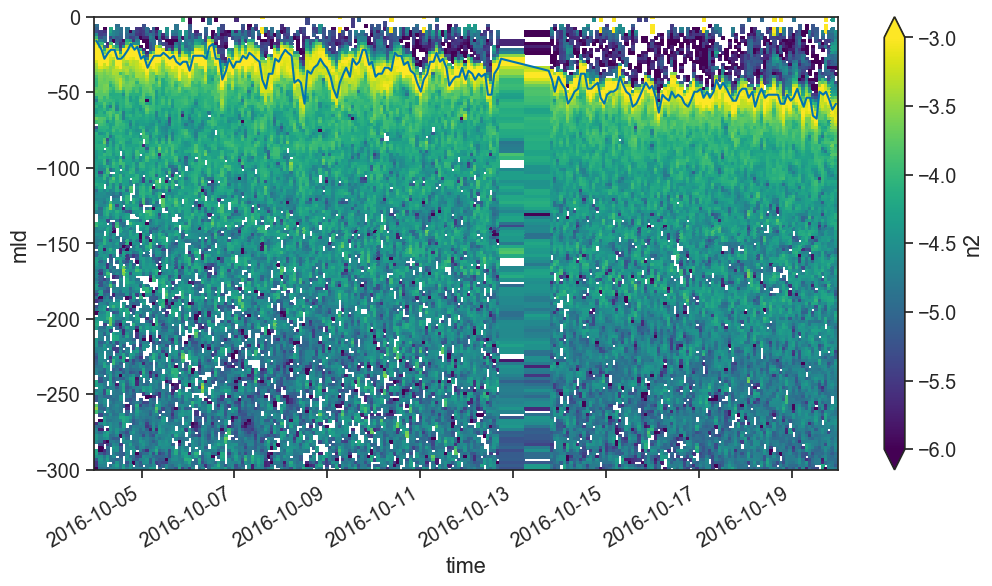

In [133]:
raw.n2.pipe(np.log10).plot(vmin=-6, vmax=-3)
raw.mld.plot()
plt.ylim(-300,0)

In [134]:
from deformtools.tools import alphabet

In [135]:
raw.to_netcdf('./ryu_plots.nc')

In [136]:
raw= xr.open_dataset('./ryu_plots.nc')

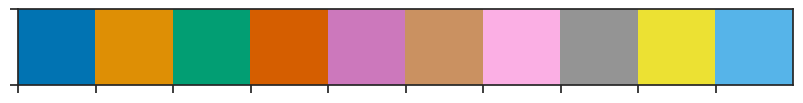

In [137]:
sns.palplot( sns.color_palette() )

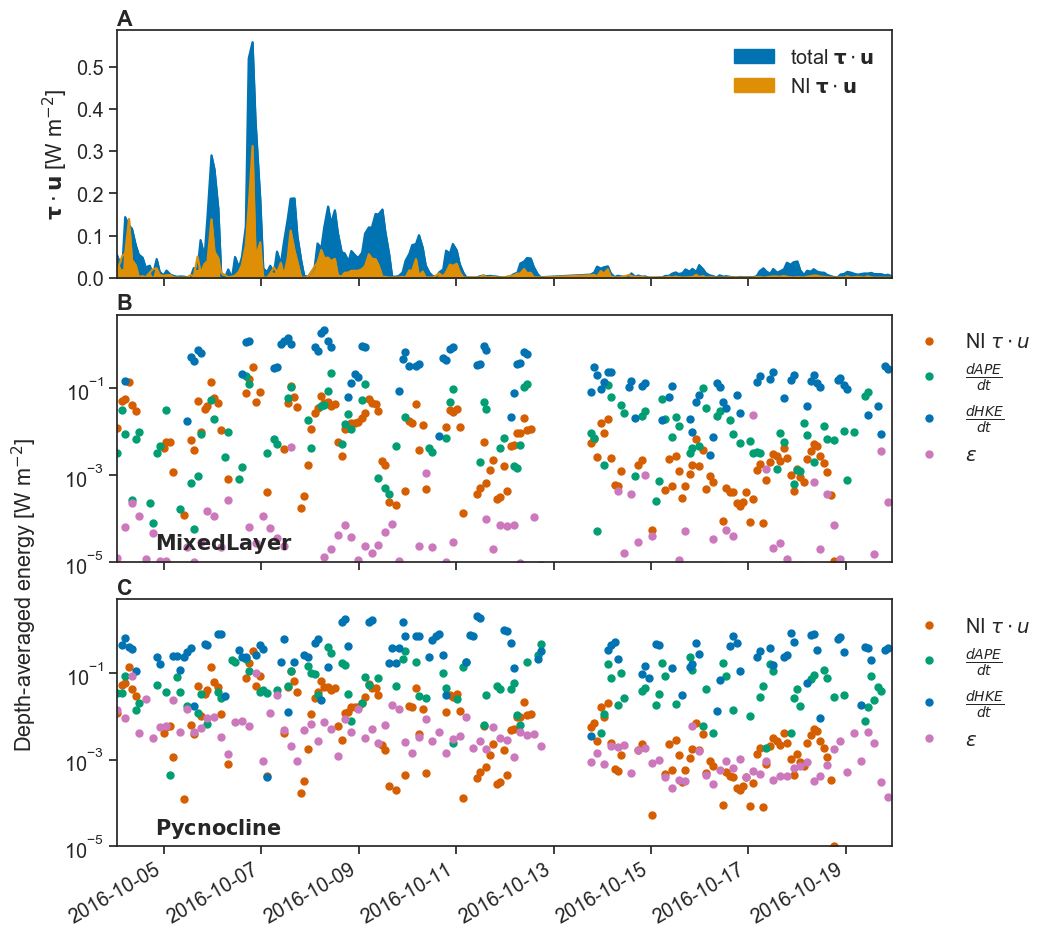

In [138]:
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1.3)
f, ax = plt.subplots(3,1, figsize=(10,12), sharex=True)

raw.taudotu.to_series().abs().plot.area(label=r'total $\mathbf{\tau} \cdot \mathbf{u}$',ax=ax[0])
raw.taudotu_ni.to_series().abs().plot.area(label=r'NI $\mathbf{\tau} \cdot \mathbf{u}$',ax=ax[0])
# raw.taudotu_ni_ni.plot(label='both NI')
ax[0].set_ylabel(r'$\mathbf{\tau} \cdot \mathbf{u}$ [W m$^{-2}$]')
ax[0].set_xlabel(None)
plt.axhline(0, color='k')
ax[0].legend()

raw.taudotu_ni.plot(label=r'NI $\tau \cdot u$',lw=0, marker='.', color='r', ax=ax[1], ms=10)
raw.dape_ml.plot(label=r'$\frac{dAPE}{dt}$',lw=0, marker='.',color='g', ax=ax[1], ms=10)
raw.dhke_ml.plot(label=r'$\frac{dHKE}{dt}$',lw=0, marker='.', color='b', ax=ax[1], ms=10)
raw.eps_ml.pipe(lambda x: x*1).plot(label=r'$\epsilon$',lw=0, marker='.', color='C4', ax=ax[1], ms=10)
ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1));
ax[1].set_yscale('log')
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].set_ylim(1e-5,5e0)

text= r'$\mathbf{Mixed Layer}$'
ax[1].annotate(text,(0.05,0.05), xycoords='axes fraction', fontsize=15)

raw.taudotu_ni.pipe(lambda x: x).plot(label=r'NI $\tau \cdot u$',lw=0, marker='.', color='r', ax=ax[2], ms=10)
raw.dape_py.plot(label=r'$\frac{dAPE}{dt}$',lw=0, marker='.', color='g', ax=ax[2], ms=10)
raw.dhke_py.plot(label=r'$\frac{dHKE}{dt}$',lw=0, marker='.', color='b', ax=ax[2], ms=10)
raw.eps_py.pipe(lambda x: x*1).plot(label=r'$\epsilon$',lw=0, marker='.', color='C4', ax=ax[2], ms=10)
ax[2].legend(loc='upper left', bbox_to_anchor=(1, 1));
ax[2].set_yscale('log')
ax[2].set_ylim(1e-5,5e0)
ax[2].set_xlabel(None)
ax[2].set_ylabel('Depth-averaged energy [W m$^{-2}$]')
ax[2].yaxis.set_label_coords(-0.1,1.02)
text= r'$\mathbf{Pycnocline}$'
ax[2].annotate(text,(0.05,0.05), xycoords='axes fraction', fontsize=15)

plt.subplots_adjust(hspace=0.15)

alphabet(ax)

plt.savefig('../figures/depth_averaged_ryu.pdf')

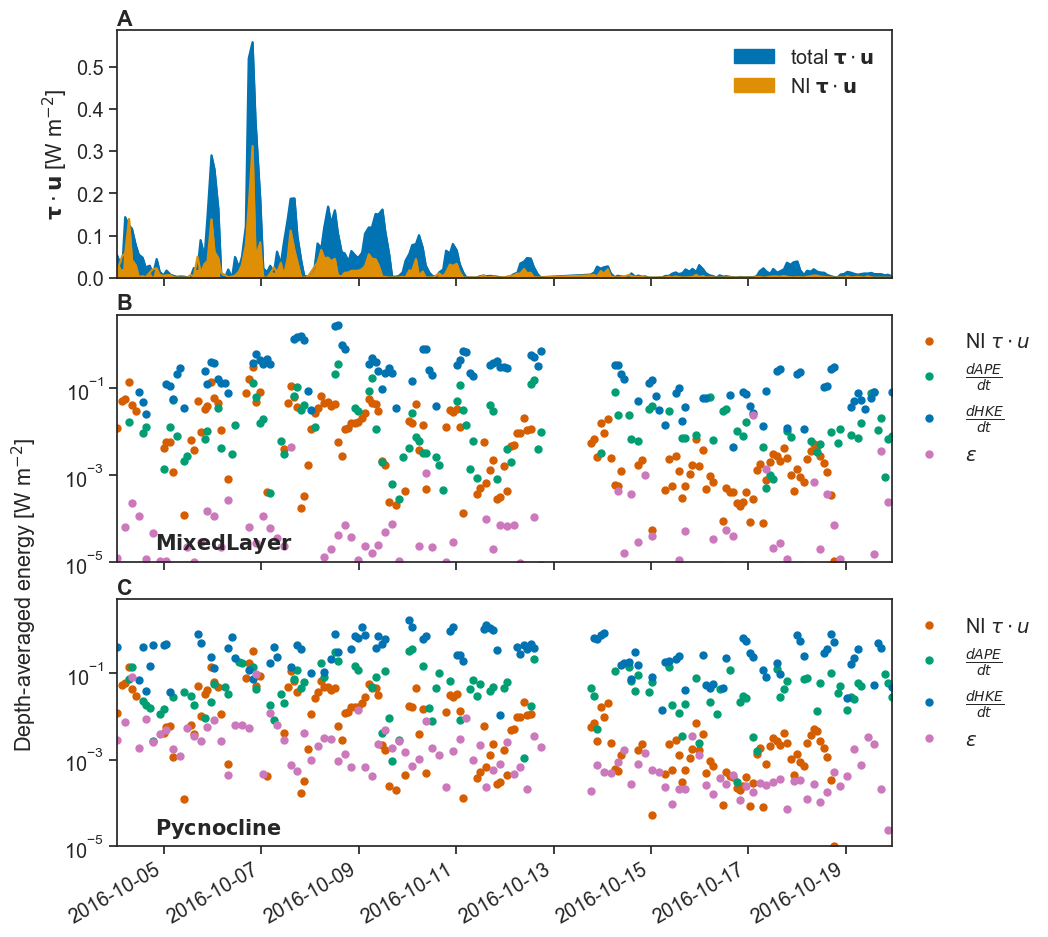

In [376]:
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1.3)
f, ax = plt.subplots(3,1, figsize=(10,12), sharex=True)

raw.taudotu.to_series().abs().plot.area(label=r'total $\mathbf{\tau} \cdot \mathbf{u}$',ax=ax[0])
raw.taudotu_ni.to_series().abs().plot.area(label=r'NI $\mathbf{\tau} \cdot \mathbf{u}$',ax=ax[0])
# raw.taudotu_ni_ni.plot(label='both NI')
ax[0].set_ylabel(r'$\mathbf{\tau} \cdot \mathbf{u}$ [W m$^{-2}$]')
ax[0].set_xlabel(None)
plt.axhline(0, color='k')
ax[0].legend()

raw.taudotu_ni.plot(label=r'NI $\tau \cdot u$',lw=0, marker='.', color='r', ax=ax[1], ms=10)
raw.dape_ml.pipe(lambda x: -x).plot(label=r'$\frac{dAPE}{dt}$',lw=0, marker='.',color='g', ax=ax[1], ms=10)
raw.dhke_ml.pipe(lambda x: -x).plot(label=r'$\frac{dHKE}{dt}$',lw=0, marker='.', color='b', ax=ax[1], ms=10)
raw.eps_ml.pipe(lambda x: x*1).plot(label=r'$\epsilon$',lw=0, marker='.', color='C4', ax=ax[1], ms=10)
ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1));
ax[1].set_yscale('log')
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].set_ylim(1e-5,5e0)

text= r'$\mathbf{Mixed Layer}$'
ax[1].annotate(text,(0.05,0.05), xycoords='axes fraction', fontsize=15)

raw.taudotu_ni.pipe(lambda x: x).plot(label=r'NI $\tau \cdot u$',lw=0, marker='.', color='r', ax=ax[2], ms=10)
raw.dape_py.pipe(lambda x: -x).plot(label=r'$\frac{dAPE}{dt}$',lw=0, marker='.', color='g', ax=ax[2], ms=10)
raw.dhke_py.pipe(lambda x: -x).plot(label=r'$\frac{dHKE}{dt}$',lw=0, marker='.', color='b', ax=ax[2], ms=10)
raw.eps_py.pipe(lambda x: x*1).plot(label=r'$\epsilon$',lw=0, marker='.', color='C4', ax=ax[2], ms=10)
ax[2].legend(loc='upper left', bbox_to_anchor=(1, 1));
ax[2].set_yscale('log')
ax[2].set_ylim(1e-5,5e0)
ax[2].set_xlabel(None)
ax[2].set_ylabel('Depth-averaged energy [W m$^{-2}$]')
ax[2].yaxis.set_label_coords(-0.1,1.02)
text= r'$\mathbf{Pycnocline}$'
ax[2].annotate(text,(0.05,0.05), xycoords='axes fraction', fontsize=15)

plt.subplots_adjust(hspace=0.15)

alphabet(ax)

# plt.savefig('../figures/depth_averaged_ryu.pdf')

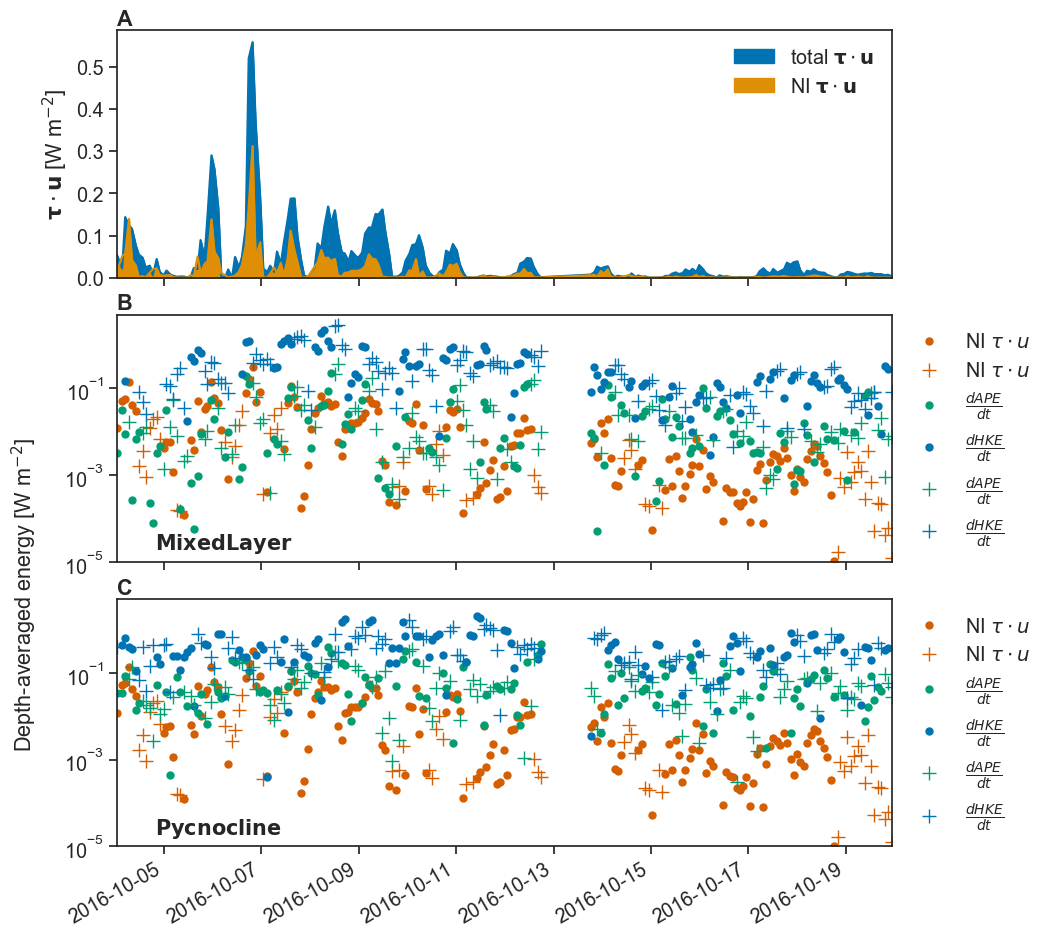

In [381]:
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1.3)
f, ax = plt.subplots(3,1, figsize=(10,12), sharex=True)

raw.taudotu.to_series().abs().plot.area(label=r'total $\mathbf{\tau} \cdot \mathbf{u}$',ax=ax[0])
raw.taudotu_ni.to_series().abs().plot.area(label=r'NI $\mathbf{\tau} \cdot \mathbf{u}$',ax=ax[0])
# raw.taudotu_ni_ni.plot(label='both NI')
ax[0].set_ylabel(r'$\mathbf{\tau} \cdot \mathbf{u}$ [W m$^{-2}$]')
ax[0].set_xlabel(None)
plt.axhline(0, color='k')
ax[0].legend()

raw.taudotu_ni.pipe(lambda x: x).plot(label=r'NI $\tau \cdot u$',lw=0, marker='.', color='r', ax=ax[1], ms=10)
raw.taudotu_ni.pipe(lambda x: -x).plot(label=r'NI $\tau \cdot u$',lw=0, marker='+', color='r', ax=ax[1], ms=10)
raw.dape_ml.pipe(lambda x: x).plot(label=r'$\frac{dAPE}{dt}$',lw=0, marker='.',color='g', ax=ax[1], ms=10)
raw.dhke_ml.pipe(lambda x: x).plot(label=r'$\frac{dHKE}{dt}$',lw=0, marker='.', color='b', ax=ax[1], ms=10)
raw.dape_ml.pipe(lambda x: -x).plot(label=r'$\frac{dAPE}{dt}$',lw=0, marker='+',color='g', ax=ax[1], ms=10)
raw.dhke_ml.pipe(lambda x: -x).plot(label=r'$\frac{dHKE}{dt}$',lw=0, marker='+', color='b', ax=ax[1], ms=10)
# raw.eps_ml.pipe(lambda x: x*1).plot(label=r'$\epsilon$',lw=0, marker='.', color='C4', ax=ax[1], ms=10)
ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1));
ax[1].set_yscale('log')
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].set_ylim(1e-5,5e0)

text= r'$\mathbf{Mixed Layer}$'
ax[1].annotate(text,(0.05,0.05), xycoords='axes fraction', fontsize=15)

raw.taudotu_ni.pipe(lambda x: x).plot(label=r'NI $\tau \cdot u$',lw=0, marker='.', color='r', ax=ax[2], ms=10)
raw.taudotu_ni.pipe(lambda x: -x).plot(label=r'NI $\tau \cdot u$',lw=0, marker='+', color='r', ax=ax[2], ms=10)
raw.dape_py.pipe(lambda x: x).plot(label=r'$\frac{dAPE}{dt}$',lw=0, marker='.',color='g', ax=ax[2], ms=10)
raw.dhke_py.pipe(lambda x: x).plot(label=r'$\frac{dHKE}{dt}$',lw=0, marker='.', color='b', ax=ax[2], ms=10)
raw.dape_py.pipe(lambda x: -x).plot(label=r'$\frac{dAPE}{dt}$',lw=0, marker='+',color='g', ax=ax[2], ms=10)
raw.dhke_py.pipe(lambda x: -x).plot(label=r'$\frac{dHKE}{dt}$',lw=0, marker='+', color='b', ax=ax[2], ms=10)
# raw.eps_py.pipe(lambda x: x*1).plot(label=r'$\epsilon$',lw=0, marker='.', color='C4', ax=ax[2], ms=10)
ax[2].legend(loc='upper left', bbox_to_anchor=(1, 1));
ax[2].set_yscale('log')
ax[2].set_ylim(1e-5,5e0)
ax[2].set_xlabel(None)
ax[2].set_ylabel('Depth-averaged energy [W m$^{-2}$]')
ax[2].yaxis.set_label_coords(-0.1,1.02)
text= r'$\mathbf{Pycnocline}$'
ax[2].annotate(text,(0.05,0.05), xycoords='axes fraction', fontsize=15)

plt.subplots_adjust(hspace=0.15)

alphabet(ax)

# plt.savefig('../figures/depth_averaged_ryu.pdf')